In [19]:
import getFeaturesFromFile
import getFeaturesWindows
import plot
import pandas as pd
import MathUtilities
import calculateTip
import os
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats
from scipy import integrate
from statsmodels.tsa.statespace.tools import diff

In [7]:
# Set data path and import data
path = r'../../../09_Data_probands'

In [12]:
def runfeaturesextract( subjectLabels,
                        scope,
                        windowSize,
                        overlapRatio,
                        path = '../../../09_Data_probands'):
    total_df = pd.DataFrame()

    #filter the database to only include the desired scope
    #subjectLabels = subjectLabels[subjectLabels['Dataset']==datasetScope]


    # Go through the file indexing all existing files
    for ind in subjectLabels.index:

        #print subjects that will be used for the model
        #print(subjectLabels[scope][ind])

        #some probands do not have data -> skip
        try:
            # DataFrame Creation with the Data by looking up the link in the excel file corresponding to proband
            reference = '/' + subjectLabels['Dataset'][ind] + '/' + subjectLabels[scope][ind] + '.csv'
            link = path + reference
            #link = path + start & end
            start, end = subjectLabels[f'Start_{scope}'][ind], subjectLabels[f'End_{scope}'][ind]


            raw_df = pd.read_csv(link)
            raw_df = raw_df.loc[start:end,:]
            raw_df = raw_df.reset_index()

            df = raw_df[['time', 'ax', 'ay', 'az', 'gx', 'gy', 'gz', 'mx', 'my', 'mz', 'psi', 'theta', 'normAccel', 'normMag','normGyr']]

            #When the length of the df changes, also change "getFeaturesFromFile.py"
            df.columns = ['time', 'accX', 'accY', 'accZ', 'gyrX', 'gyrY', 'gyrZ', 'magX', 'magY', 'magZ','psi','theta','normAccel','normMag','normGyr']

            #topDF
            totalDF = df[["time", "accX", 'accY', 'accZ','normAccel','psi','theta']]

            totalDF = totalDF.rename(columns={'accX': "accX_Top", 'accY': "accY_Top", 'accZ': "accZ_Top"})

            #totalDF = df[["time", "accX", 'accY', 'accZ']].rename(index={1: "AccX_Top", 2: "AccY_Top", 3: "AccZ_Top"})
            #tipDF is the dataframe that contains the vectors of the tip of the pen (Acceleration in three directions + psi, theta)
            tipDF = calculateTip.calculateTip(totalDF)
            totalDF = pd.concat([totalDF,tipDF], axis=1)

            #calculate integration

            # integrate.cumtrapz(totalDF['accX_Top'],initial = 0)
            accX_top_diff = diff(totalDF['accX_Top'], k_diff=1)
            accY_top_diff = diff(totalDF['accY_Top'], k_diff=1)
            accZ_top_diff = diff(totalDF['accZ_Top'], k_diff=1)
            acc_comb = round(accX_top_diff + accY_top_diff + accZ_top_diff,5)

            # plt.figure()
            # sns.lineplot(totalDF['time'], totalDF['accY_Tip'])
            # sns.lineplot(totalDF['time'], totalDF['accY_Top'])
            # plt.show()
            #sns.lineplot(totalDF['time'], totalDF['accY_Tip'])
            #sns.lineplot(totalDF['time'], totalDF['accZ_Top'])
            #plt.show()

            #sns.lineplot(totalDF['time'], totalDF['psi'])
            #sns.lineplot(totalDF['time'], totalDF['theta'])
            # plt.show()

            # sns.lineplot(data['time'], data['accY_Top'])
            # sns.lineplot(data['time'], data['accZ_Top'])


            # Pass dataframe through window and set isRaw to False
            featuresByWindowDF = getFeaturesWindows.passThroughWindow(totalDF, False, windowSize, overlapRatio)

            # Insert label of subject
            featuresByWindowDF.insert(0, 'subjectLabel', subjectLabels['Dataset'][ind] + "_" + subjectLabels['Subject'][ind])

            #Insert BHK scores of subject - insert command for insertion at specific space
            featuresByWindowDF.insert(1, 'BHK_speed', subjectLabels['Speed_score'][ind])
            featuresByWindowDF.insert(2, 'BHK_quality', subjectLabels['Quality_score'][ind])

            #Insert classification labels of subject
            featuresByWindowDF.insert(3, 'Class_binary', subjectLabels['Classification_binary'][ind])
            featuresByWindowDF.insert(4, 'Class_three', subjectLabels['Classification_three'][ind])

            #Add Age and Gender to the features
            featuresByWindowDF["Age"] = subjectLabels["Age"][ind]
            featuresByWindowDF["Gender"] = int(subjectLabels["Gender (0=boys)"][ind])

            pd.set_option('display.max_columns', None)

            total_df = pd.concat([total_df,featuresByWindowDF], axis=0)

        except TypeError:
            pass
    return total_df

In [26]:
path = r"../../../09_Data_probands/"
subjectLabels = pd.read_excel(path + 'Data_summary_all.xlsx', header=0)

# define windowsize
windowSize = 200

#define the overlapping ratio meaning: windowStart += math.floor(dataWindow / overlapRatio)
# 1 is resulting in no overlap
# 2 results in 50% overlap
overlapRatio = 1

#define scope: 'Link_loops'/'Link_sentences'
scope = 'Link_loops'

#define scope of Dataset
datasetScope = 'Children'

#extract features by window
total_df_200 = runfeaturesextract(subjectLabels,
                scope,
                windowSize,
                overlapRatio)

total_df_400 = runfeaturesextract(subjectLabels,
                scope,
                400,
                overlapRatio)

In [34]:
#check assumptions to use ANOVA
#1. Homogeneity of variance Assumption Check
#ratio between max and min sd must be lower than 2

variables = ["AZ_mean","AZ_max","AZ_min","AZ_std","AZ_var","AL_mean","AL_max","AL_min","AL_std","AL_var","AZ_diff_mean","AZ_diff_max","AZ_diff_min","AZ_diff_std","AZ_diff_var","AL_diff_mean","AL_diff_max","AL_diff_min","AL_diff_std","AL_diff_var","AL_percentile_60","acceleration_mean","acceleration_max","acceleration_min","acceleration_D","jerk_mean","jerk_max","jerk_min","jerk_std","jerk_mad","jerk_skew","jerk_entropy","nb_max_acc","nb_min_acc"]

variables_ok = []
for variable in variables:
    ratio = total_df_200.groupby('Class_binary').std()[variable].max() / total_df_200.groupby('Class_binary').std()[variable].min()
    print("Variable: " + variable)
    if ratio < 2:
        print(f"Ratio = {ratio} - Assumption OK")
        variables_ok.append(variable)
    else:
        print(f"Ratio = {ratio} - Assumption rejected")

Variable: AZ_mean
Ratio = 1.6491228652980647 - Assumption OK
Variable: AZ_max
Ratio = 1.8098369869134563 - Assumption OK
Variable: AZ_min
Ratio = 1.2177373705011656 - Assumption OK
Variable: AZ_std
Ratio = 1.04080088814387 - Assumption OK
Variable: AZ_var
Ratio = 1.1547649510761542 - Assumption OK
Variable: AL_mean
Ratio = 1.1646643271698889 - Assumption OK
Variable: AL_max
Ratio = 1.7690720234838881 - Assumption OK
Variable: AL_min
Ratio = 1.2093580035355713 - Assumption OK
Variable: AL_std
Ratio = 1.646310989123036 - Assumption OK
Variable: AL_var
Ratio = 2.921214982021946 - Assumption rejected
Variable: AZ_diff_mean
Ratio = 1.1020209790601951 - Assumption OK
Variable: AZ_diff_max
Ratio = 1.182054086330579 - Assumption OK
Variable: AZ_diff_min
Ratio = 1.3765162956547323 - Assumption OK
Variable: AZ_diff_std
Ratio = 1.728295119984367 - Assumption OK
Variable: AZ_diff_var
Ratio = 3.128997908924437 - Assumption rejected
Variable: AL_diff_mean
Ratio = 1.7875595968764533 - Assumption OK
V

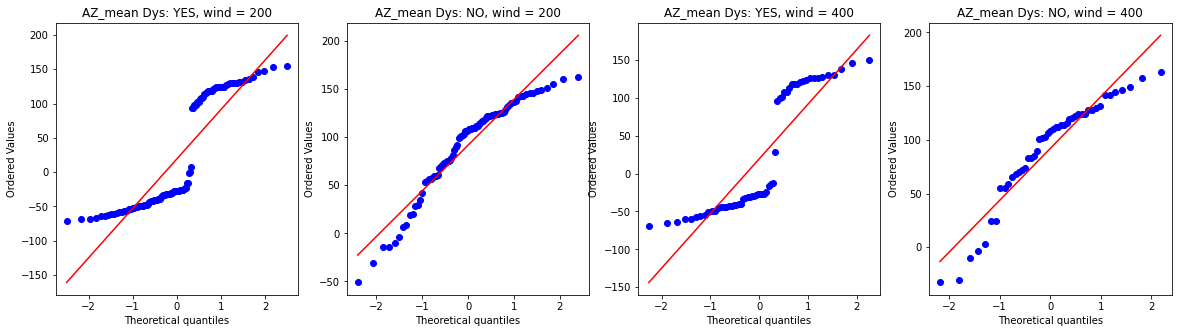

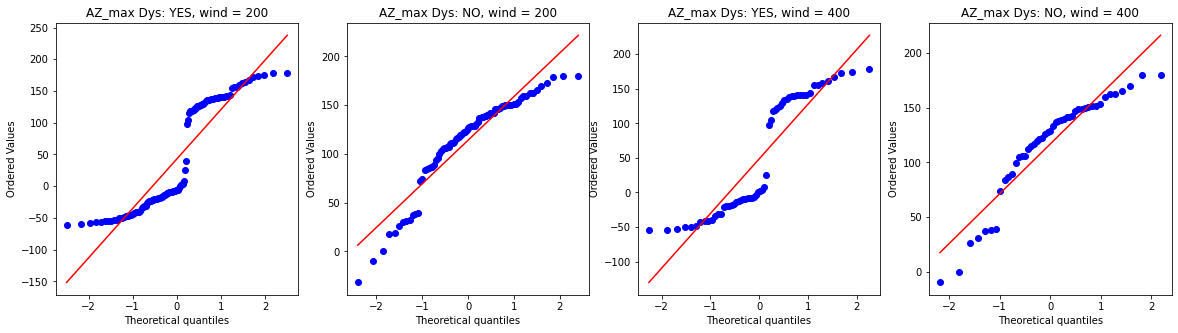

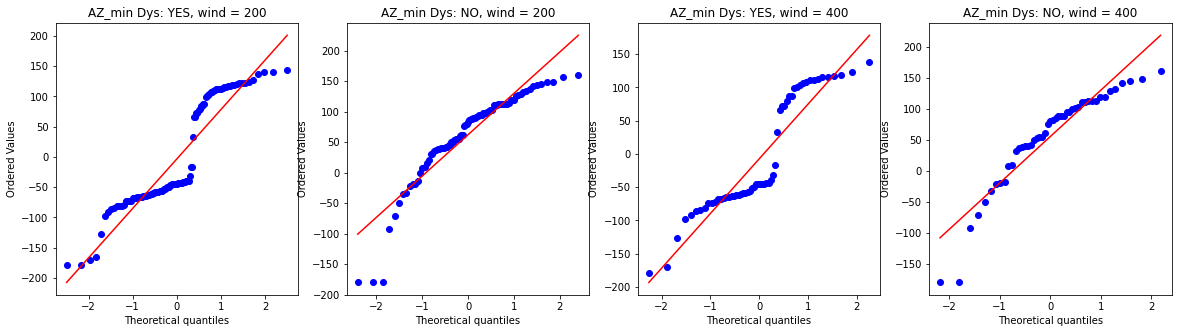

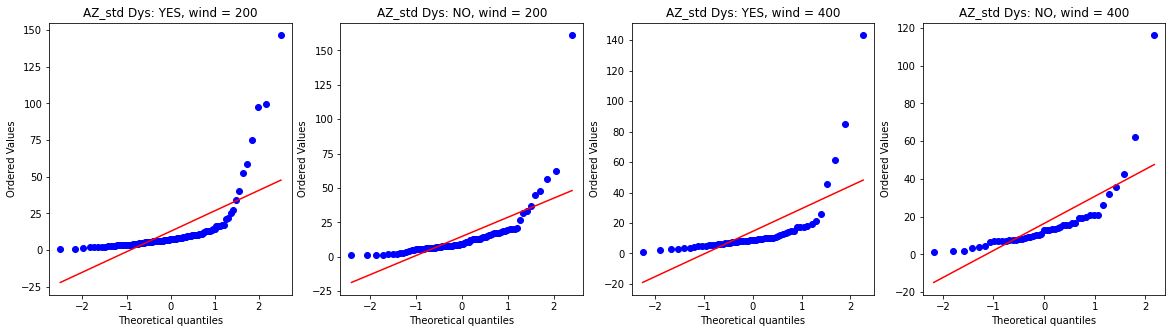

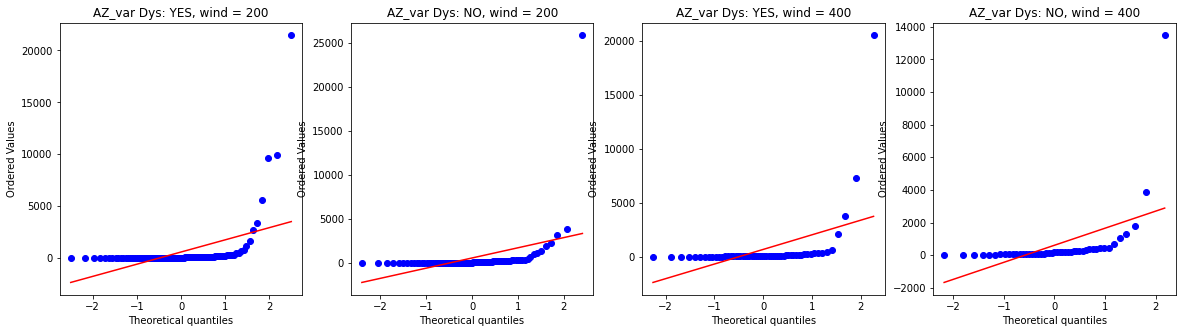

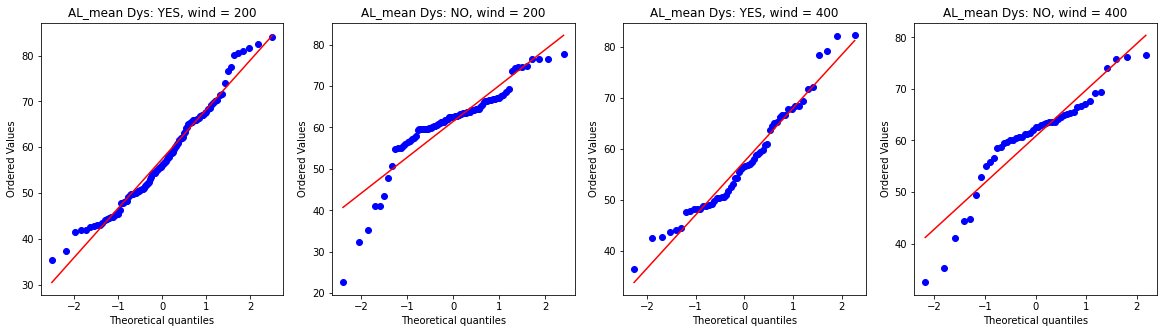

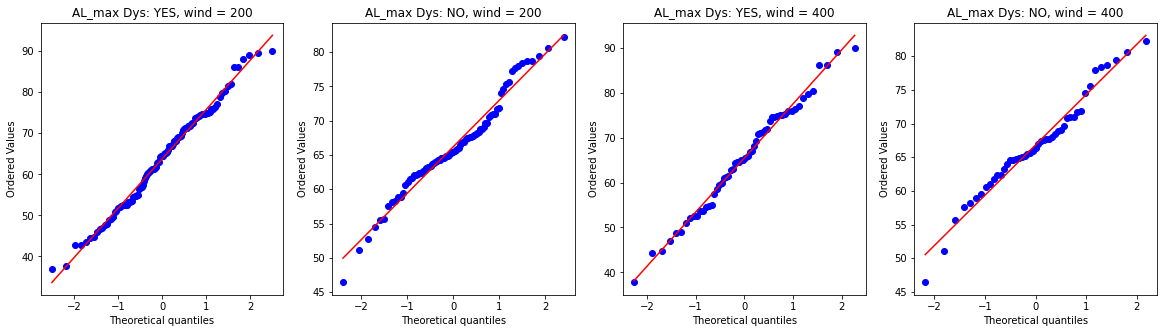

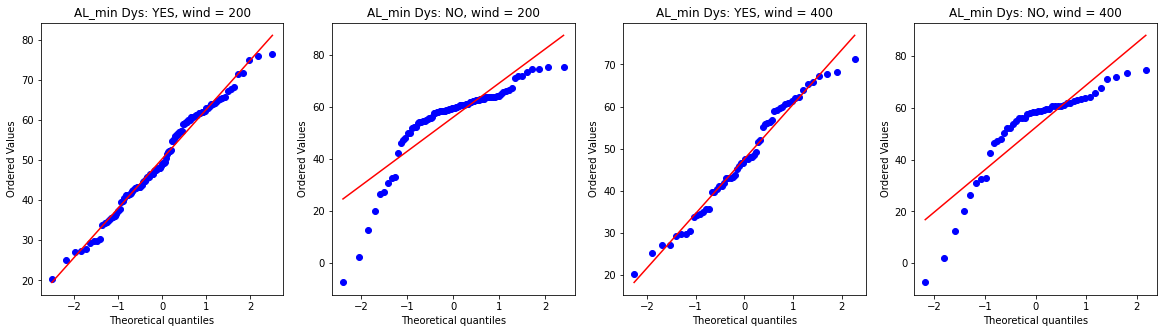

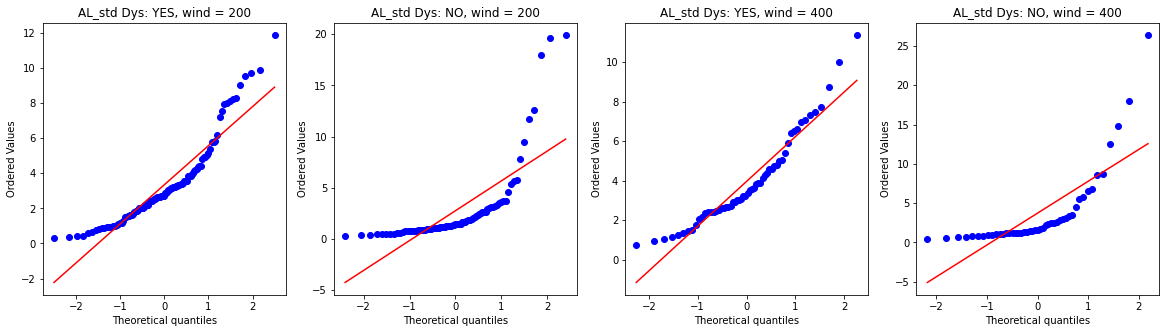

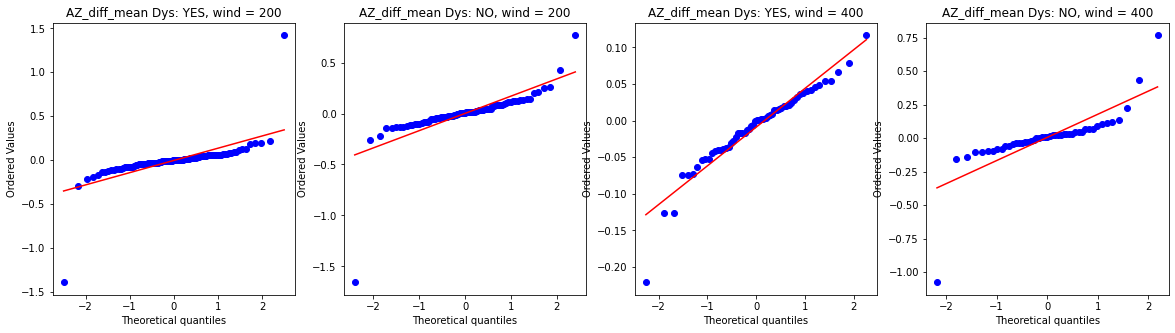

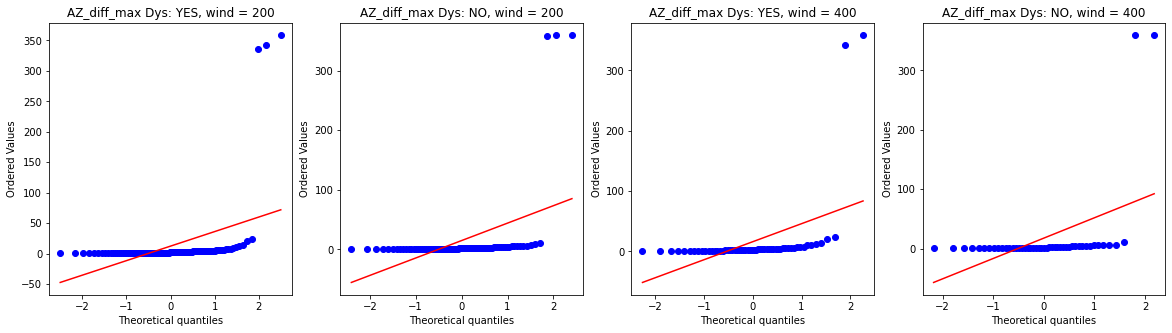

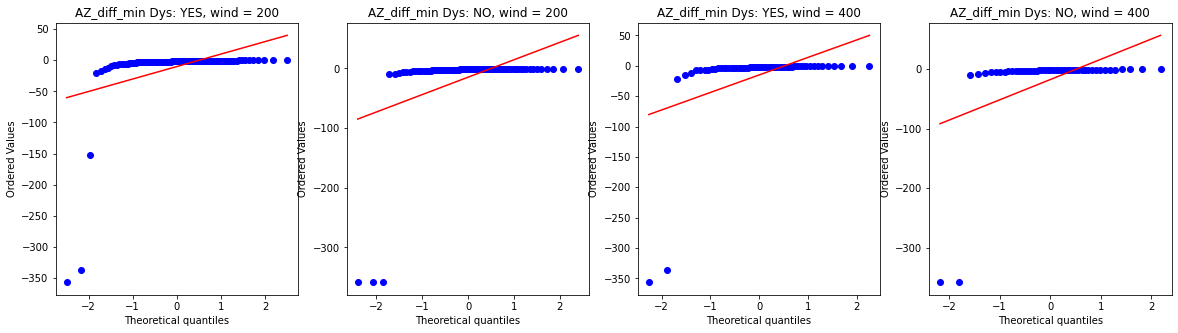

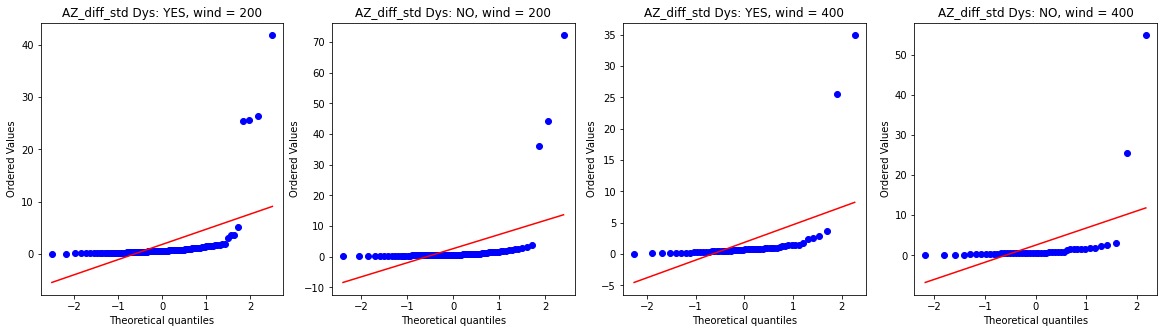

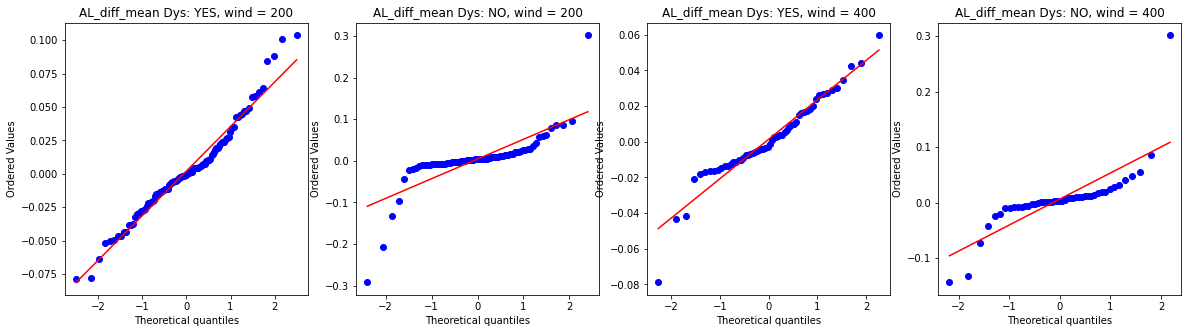

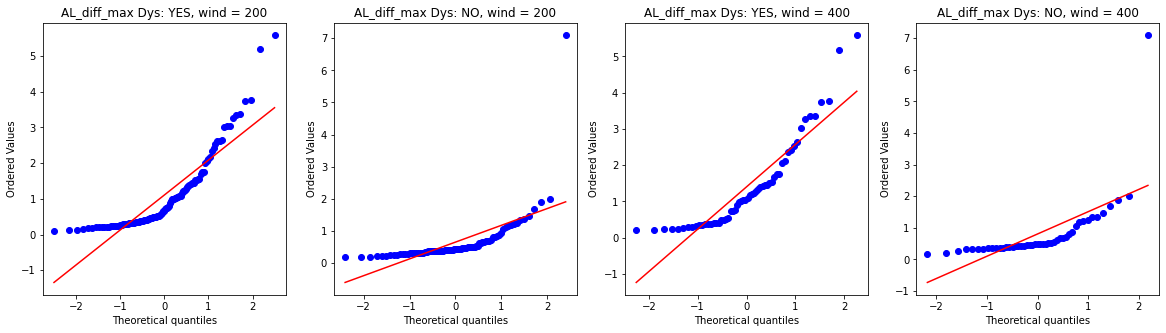

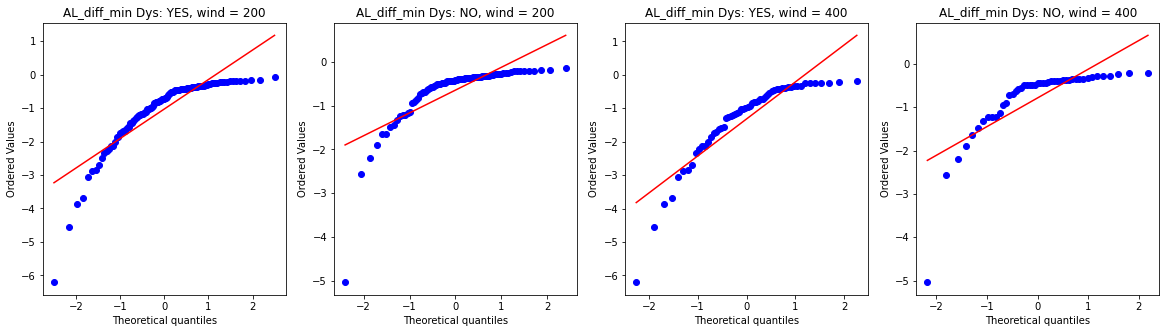

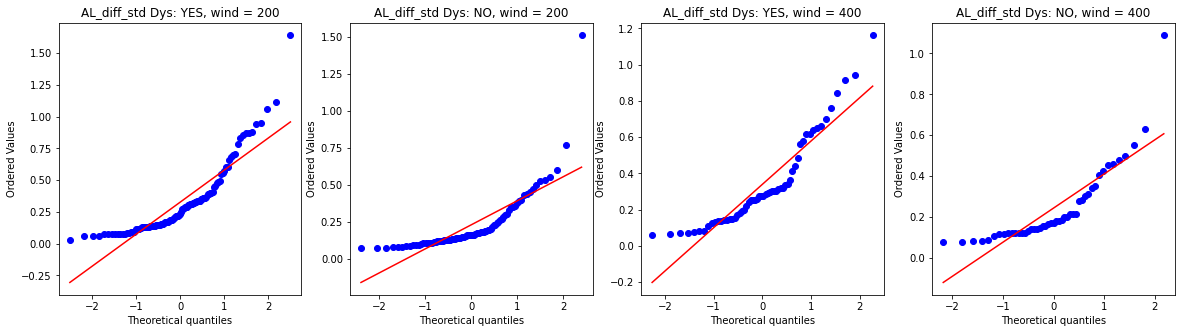

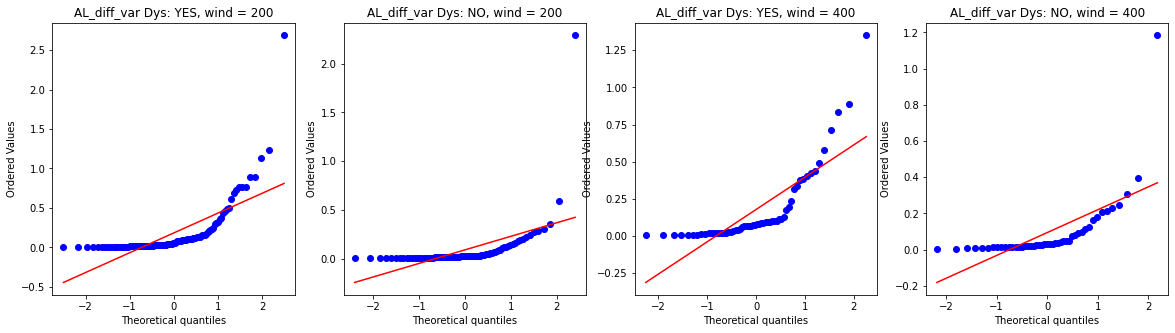

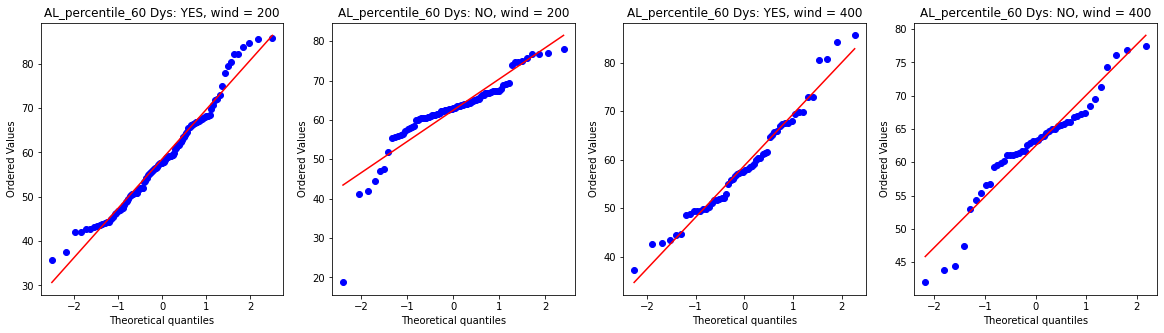

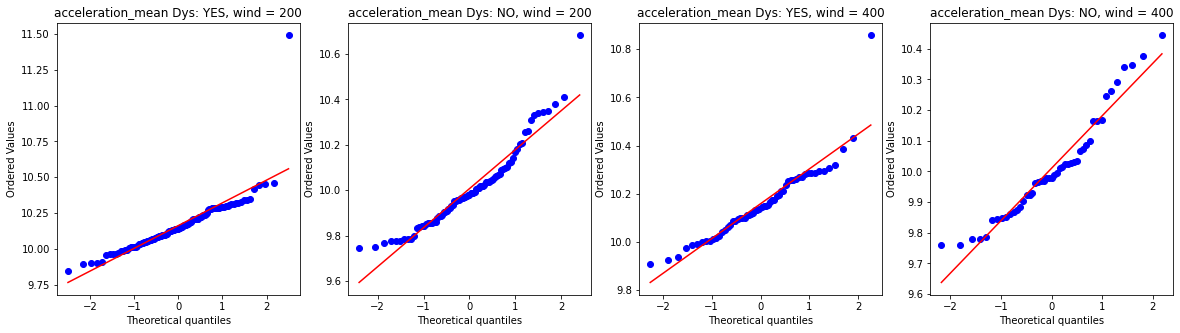

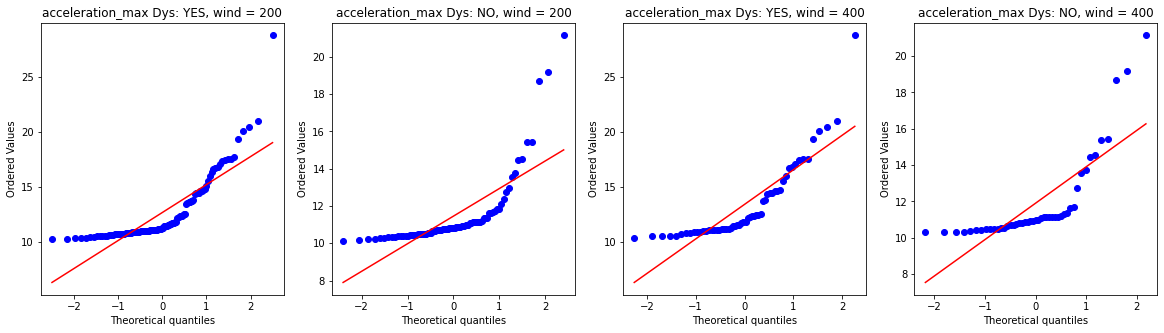

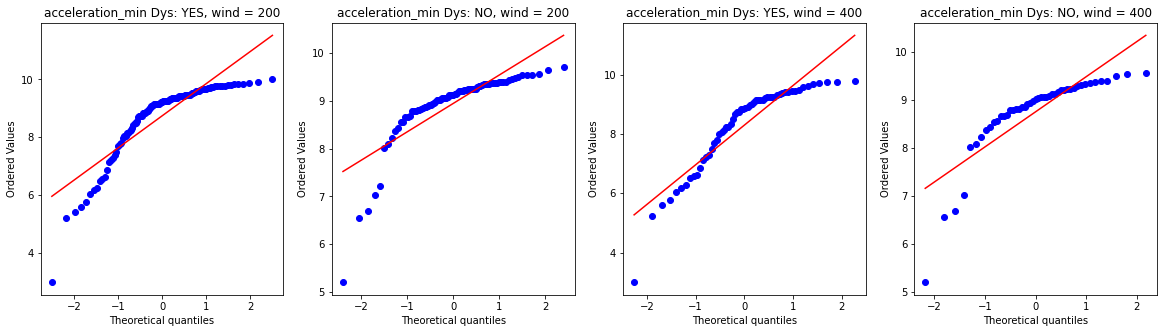

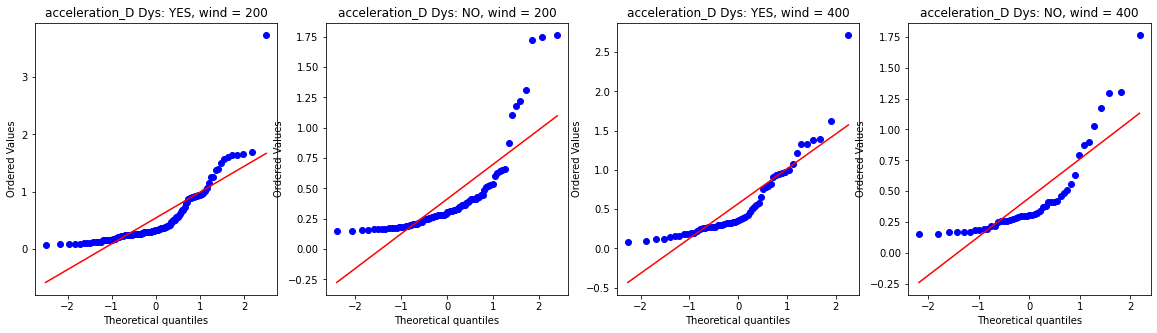

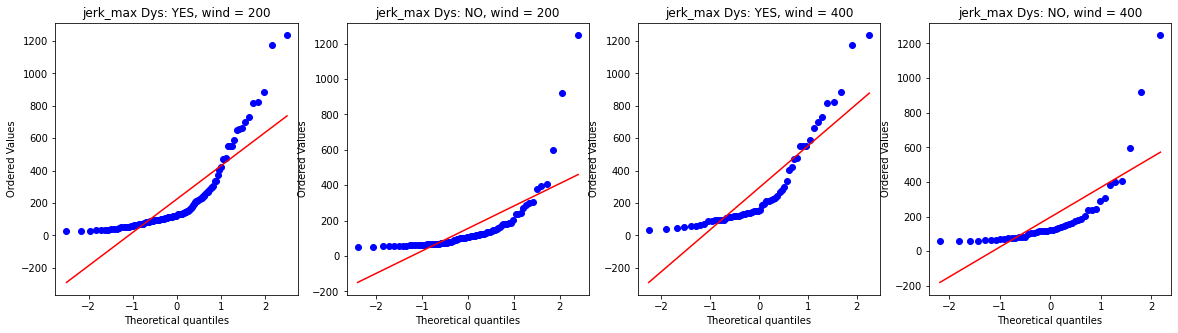

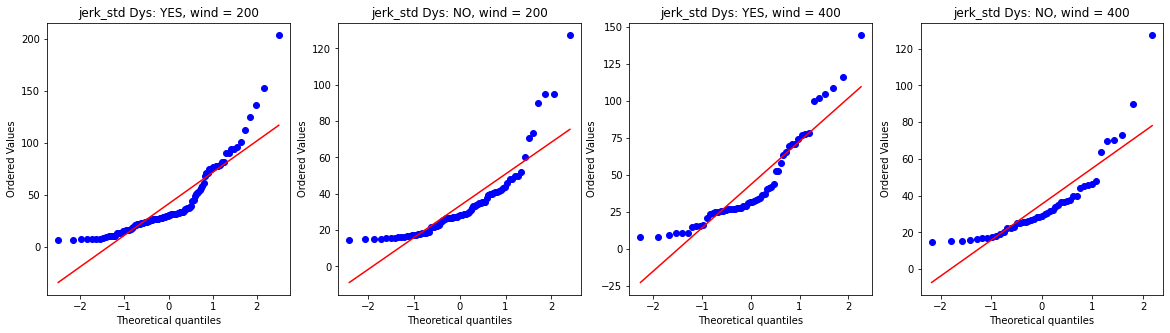

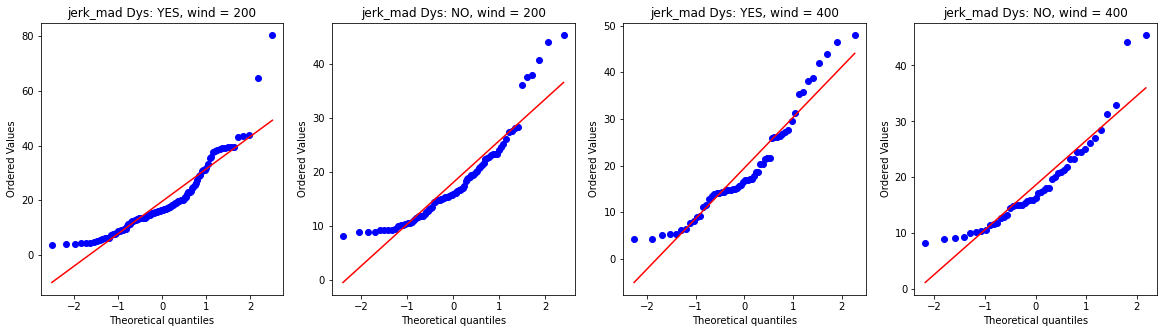

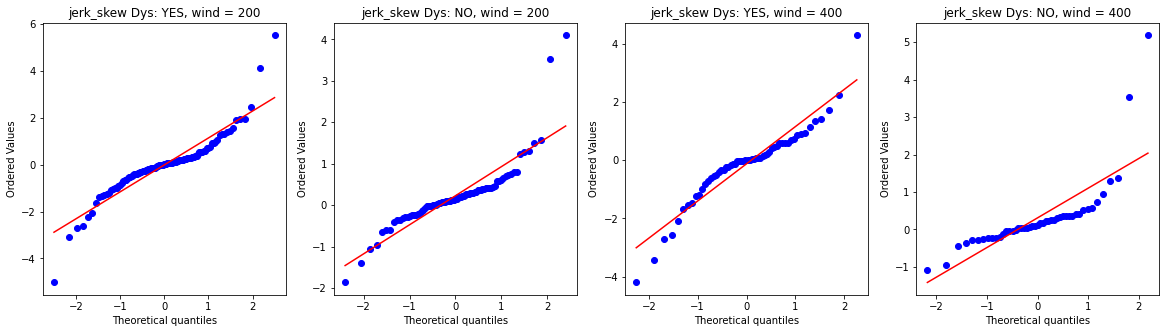

In [35]:
#2. Normality Assumption

#plot it for two different window size to verify that it does not depend on the window size
for variable in variables_ok:
    fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize = (20,5))

    stats.probplot(total_df_200[total_df_200['Class_binary'] == "yes"][variable], dist="norm", plot=ax1)
    stats.probplot(total_df_200[total_df_200['Class_binary'] == "no"][variable], dist="norm", plot=ax2)

    stats.probplot(total_df_400[total_df_400['Class_binary'] == "yes"][variable], dist="norm", plot=ax3)
    stats.probplot(total_df_400[total_df_400['Class_binary'] == "no"][variable], dist="norm", plot=ax4)

    ax1.set_title(variable + " Dys: YES, wind = 200")
    ax2.set_title(variable + " Dys: NO, wind = 200")

    ax3.set_title(variable + " Dys: YES, wind = 400")
    ax4.set_title(variable + " Dys: NO, wind = 400")

    plt.show()

In [37]:
variables_test = ["AL_max",
                "AZ_diff_mean",
                "AL_percentile_60",
                "acceleration_mean",
                "jerk_mad",
                "jerk_skew"]

In [51]:
#RUN ANOVA TEST
variables_different = []

for variable in variables_test:
    print(f"\n Test for {variable}")
    test = stats.f_oneway(total_df_200[variable][total_df_200['Class_binary'] == 'yes'],
                    total_df_200[variable][total_df_200['Class_binary'] == 'no'])
    print(f"P-value = {test[1]}")
    if test[1]<0.05:
        print("Null Hypothesis rejected -> Significant difference in mean")
        variables_different.append(variable)
    else:
        print("Fail to reject null hypothesis -> No significant difference")


 Test for AL_max
P-value = 0.09260483284749489
Fail to reject null hypothesis -> No significant difference

 Test for AZ_diff_mean
P-value = 0.8558116546360626
Fail to reject null hypothesis -> No significant difference

 Test for AL_percentile_60
P-value = 0.007520686294114535
Null Hypothesis rejected -> Significant difference in mean

 Test for acceleration_mean
P-value = 6.427173155127691e-09
Null Hypothesis rejected -> Significant difference in mean

 Test for jerk_mad
P-value = 0.33849527807496627
Fail to reject null hypothesis -> No significant difference

 Test for jerk_skew
P-value = 0.11864782861870649
Fail to reject null hypothesis -> No significant difference


In [55]:
import math

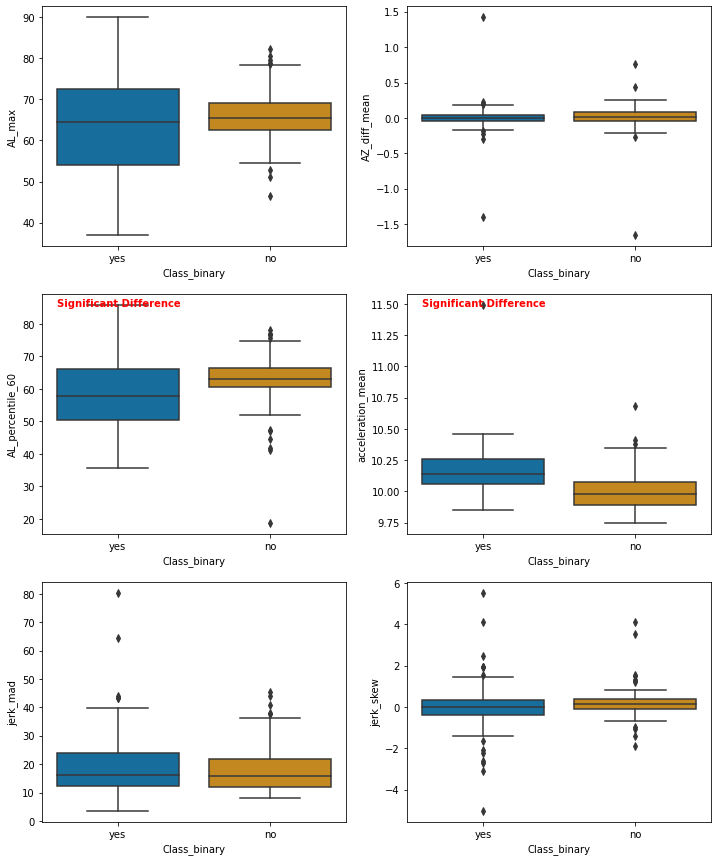

In [66]:
#PLOT BOXPLOTS
variables_plot = variables_test
rows = math.ceil(len(variables_plot)/2)
fig,axs = plt.subplots(rows, 2, figsize = (12,5*rows))
a = 0
for ax in axs.ravel():
    sns.boxplot(y= variables_plot[a], x='Class_binary', 
                 data=total_df_200, 
                 palette="colorblind",
                 ax = ax)
    if variables_plot[a] in variables_different:
        plt.text(0.05, 0.95, "Significant Difference", fontweight="bold", c = "red", transform=ax.transAxes)
    a+=1